In [1]:
# importing libraries

import re

import numpy as np 
import pandas as pd 

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D
from tensorflow.keras.layers import Flatten, Dense, concatenate, Conv1D, Dropout, Input, BatchNormalization

In [2]:
# loading the csv files

# train
train = pd.read_csv('/kaggle/input/donorschoose-application-screening/train.zip')
print('Train data shape: ', train.shape)

# test
test = pd.read_csv('/kaggle/input/donorschoose-application-screening/test.zip')
print('Test data shape: ', test.shape)

# sample submission
sample = pd.read_csv('/kaggle/input/donorschoose-application-screening/sample_submission.zip')
print('Sample data shape: ', sample.shape)

Train data shape:  (182080, 16)
Test data shape:  (78035, 15)
Sample data shape:  (78035, 2)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [4]:
# replacing the NaN values in train data as 'unknown'
train.fillna("unknown", inplace=True)

In [5]:
test.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects
0,p233245,5724a0c3ce11008366fff36dab4b943c,Ms.,CA,2016-04-27 13:45:41,Grades PreK-2,Music & The Arts,Visual Arts,Art Will Make You Happy!,My 2nd grade students are amazing! They are v...,My class is made up of 12 boys and 12 girls. ...,My second grade class will really benefit from...,The genorous donations to my project will make...,My students need a drying rack for their art p...,2
1,p096795,445619941dc7cbe81c7be109dc61a56a,Mrs.,SC,2016-04-28 12:43:56,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Keeping up with the TIMEs,Students within the classroom work in small gr...,My students are all very talented young indivi...,"We do a lot of small group, where the student ...",This project is very important to my classroom...,My students need Time Magazines for next year ...,1
2,p236235,e92a4902b1611a189643d6f12c51e6a0,Mrs.,SC,2016-04-29 21:16:05,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Building Bridges to Problem Solving,My students share a love of learning. These s...,My class consists of 14 energetic learners. O...,These Fairy Tale Problem Solving STEM kits wil...,These materials will be help my students with ...,My students need to be mentally stimulated to ...,0
3,p233680,8e92622d2985d3faac1de71609c4be72,Mrs.,IA,2016-04-27 22:32:43,Grades PreK-2,Literacy & Language,Literacy,Classroom Library,Reading is the gateway to the soul. Guiding c...,First graders enter the classroom each day rea...,Book bins will help to organize our classroom ...,"When students begin the first grade, many are ...",My students need an organized classroom library.,0
4,p171879,91a3c89981f626d9a0d067c65fb186ce,Mr.,CA,2016-04-27 18:59:15,Grades 6-8,"Music & The Arts, Special Needs","Performing Arts, Special Needs",Reeds so we can Read,"\""Mr. Reyes! I need another reed!\"" I hear t...",We have a diverse population with almost entir...,Each day in my class students consume supplies...,My students come from very troubled homes and ...,My students need reeds to perform in class eac...,1


In [6]:
# replacing the NaN values in test data as 'unknown'
test.fillna('unknown', inplace=True)

# 1. Basic Text Preprocessing

In [7]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

## project_essay

In [9]:
# Combining project_essay_1, project_essay_2. project_essay_3, project_essay_4 into one column project_essay

# train
train['project_essay'] = train['project_essay_1'] + ' ' + train['project_essay_2'] + ' ' + train['project_essay_3'] + ' ' + train['project_essay_4']


# test
test['project_essay'] = test['project_essay_1'] + ' ' + test['project_essay_2'] + ' ' + test['project_essay_3'] + ' ' + test['project_essay_4']

In [10]:
# preprocessing

# train
preprocessed_project_essay = []
for sentance in tqdm(train['project_essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_project_essay.append(sent.lower().strip())
    
    
train['project_essay'] = preprocessed_project_essay

100%|██████████| 182080/182080 [02:24<00:00, 1260.32it/s]


In [11]:
# preprocessing

# test
preprocessed_project_essay = []
for sentance in tqdm(test['project_essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_project_essay.append(sent.lower().strip())
    
    
test['project_essay'] = preprocessed_project_essay

100%|██████████| 78035/78035 [01:02<00:00, 1256.40it/s]


## project_title

In [12]:
# preprocessing

# train
preprocessed_project_title = []
for sentance in tqdm(train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_project_title.append(sent.lower().strip())
    
    
train['project_title'] = preprocessed_project_title

100%|██████████| 182080/182080 [00:06<00:00, 27373.08it/s]


In [13]:
# preprocessing

# test
preprocessed_project_title = []
for sentance in tqdm(test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_project_title.append(sent.lower().strip())
    
    
test['project_title'] = preprocessed_project_title

100%|██████████| 78035/78035 [00:02<00:00, 26042.01it/s]


## project_resource_summary

In [14]:
# preprocessing

# train
preprocessed_resource_summary = []
for sentance in tqdm(train['project_resource_summary'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_resource_summary.append(sent.lower().strip())
    
    
train['project_resource_summary'] = preprocessed_resource_summary

100%|██████████| 182080/182080 [00:14<00:00, 12510.94it/s]


In [15]:
# preprocessing

# test
preprocessed_resource_summary = []
for sentance in tqdm(test['project_resource_summary'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_resource_summary.append(sent.lower().strip())
    
    
test['project_resource_summary'] = preprocessed_resource_summary


100%|██████████| 78035/78035 [00:06<00:00, 12019.64it/s]


# Train Validation Split

In [16]:
# project_is_approved is the target variable. 
y = train['project_is_approved']
train.drop(['project_is_approved'], axis=1, inplace=True)

In [17]:
# Dropping Some Unneccsary columns

train.drop(['id', 'teacher_id', 'project_submitted_datetime', 'project_essay_1', 'project_essay_2', \
            'project_essay_3', 'project_essay_4'], inplace=True, axis=1)

test.drop(['id', 'teacher_id', 'project_submitted_datetime', 'project_essay_1', 'project_essay_2', \
           'project_essay_3', 'project_essay_4'], inplace=True, axis=1)

print(train.shape)
print(test.shape)

(182080, 9)
(78035, 9)


In [18]:
# splitting data into train and vaildation
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, stratify=y)

In [19]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(test.shape)

(145664, 9) (145664,)
(36416, 9) (36416,)
(78035, 9)


# Enocding Categorical Data

In [20]:
X_train.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_essay
149644,Mrs.,MO,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",mrs martin class needs comfort r ouch bottoms ...,students need rug comfortable floor seating op...,0,believe students shining stars smaller high po...
70279,Mrs.,AZ,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",zooming math time,students need timers stopwatches clocks stamps...,3,teacher low income high poverty neighborhood s...
76956,Mr.,NY,Grades 6-8,Math & Science,"Environmental Science, Health & Life Science",students use data reach state science standards,students need test forms order collect analyze...,0,students mostly residents bushwick brooklyn ag...
88793,Ms.,NY,Grades PreK-2,Math & Science,Mathematics,count,students need math activities explore independ...,14,wonderful diverse group students six different...
109808,Mrs.,MO,Grades PreK-2,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",choice working comfortable,students need clipboards able work around room,9,building stem science technology engineering m...


In [21]:
# teacher_prefix 

encoder = LabelEncoder()

teacher_prefix_train = encoder.fit_transform(X_train['teacher_prefix'].values.reshape(-1, 1))
teacher_prefix_val = encoder.transform(X_val['teacher_prefix'].values.reshape(-1, 1))
teacher_prefix_test = encoder.transform(test['teacher_prefix'].values.reshape(-1, 1))

# reshaping
teacher_prefix_train = teacher_prefix_train.reshape(-1, 1)
teacher_prefix_val = teacher_prefix_val.reshape(-1, 1)
teacher_prefix_test = teacher_prefix_test.reshape(-1, 1)

print(teacher_prefix_train.shape)
print(teacher_prefix_val.shape)
print(teacher_prefix_test.shape)

(145664, 1)
(36416, 1)
(78035, 1)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [22]:
# school_state 

encoder = LabelEncoder()

school_state_train = encoder.fit_transform(X_train['school_state'].values.reshape(-1, 1))
school_state_val = encoder.transform(X_val['school_state'].values.reshape(-1, 1))
school_state_test = encoder.transform(test['school_state'].values.reshape(-1, 1))

# reshaping
school_state_train = school_state_train.reshape(-1, 1)
school_state_val = school_state_val.reshape(-1, 1)
school_state_test = school_state_test.reshape(-1, 1)

print(school_state_train.shape)
print(school_state_val.shape)
print(school_state_test.shape)

(145664, 1)
(36416, 1)
(78035, 1)


In [23]:
# project_grade_category

encoder = LabelEncoder()

project_grade_category_train = encoder.fit_transform(X_train['project_grade_category'].values.reshape(-1, 1))
project_grade_category_val = encoder.transform(X_val['project_grade_category'].values.reshape(-1, 1))
project_grade_category_test = encoder.transform(test['project_grade_category'].values.reshape(-1, 1))

# reshaping
project_grade_category_train = project_grade_category_train.reshape(-1, 1)
project_grade_category_val = project_grade_category_val.reshape(-1, 1)
project_grade_category_test = project_grade_category_test.reshape(-1, 1)

print(project_grade_category_train.shape)
print(project_grade_category_val.shape)
print(project_grade_category_test.shape)

(145664, 1)
(36416, 1)
(78035, 1)


In [24]:
# project_subject_categories

encoder = LabelEncoder()

subject_categories_train = encoder.fit_transform(X_train['project_subject_categories'].values.reshape(-1, 1))
subject_categories_val = encoder.transform(X_val['project_subject_categories'].values.reshape(-1, 1))
subject_categories_test = encoder.transform(test['project_subject_categories'].values.reshape(-1, 1))

# reshaping
subject_categories_train = subject_categories_train.reshape(-1, 1)
subject_categories_val = subject_categories_val.reshape(-1, 1)
subject_categories_test = subject_categories_test.reshape(-1, 1)

print(subject_categories_train.shape)
print(subject_categories_val.shape)
print(subject_categories_test.shape)

(145664, 1)
(36416, 1)
(78035, 1)


In [25]:
# project_subject_subcategories

encoder = LabelEncoder()

subject_subcategories_train = encoder.fit_transform(X_train['project_subject_subcategories'].values.reshape(-1, 1))
encoder_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

subject_subcategories_train = encoder.transform(X_train['project_subject_subcategories'].values.reshape(-1, 1))

subject_subcategories_val = X_val['project_subject_subcategories'].apply(lambda x: encoder_dict.get(x, 500))

subject_subcategories_test = test['project_subject_subcategories'].apply(lambda x: encoder_dict.get(x, 500))


# reshaping
subject_subcategories_train = subject_subcategories_train.reshape(-1, 1)
subject_subcategories_val = subject_subcategories_val.values.reshape(-1, 1)
subject_subcategories_test = subject_subcategories_test.values.reshape(-1, 1)

print(subject_subcategories_train.shape)
print(subject_subcategories_val.shape)
print(subject_subcategories_test.shape)

(145664, 1)
(36416, 1)
(78035, 1)


In [26]:
# this is a numerical feature. it doesn't need encoding. 

previous_projects_train = X_train['teacher_number_of_previously_posted_projects'].values
previous_projects_val = X_val['teacher_number_of_previously_posted_projects'].values
previous_projects_test = test['teacher_number_of_previously_posted_projects'].values

print(previous_projects_train.shape)
print(previous_projects_val.shape)
print(previous_projects_test.shape)

(145664,)
(36416,)
(78035,)


# Tokenizing Text Data

In [27]:
max_sequence_len = 256

In [28]:
# project_title


# Tokenize our training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['project_title'])

# Encode data sentences into sequences
project_title_train = tokenizer.texts_to_sequences(X_train['project_title'])
project_title_val = tokenizer.texts_to_sequences(X_val['project_title'])
project_title_test = tokenizer.texts_to_sequences(test['project_title'])



# Pad the training sequences
project_title_train = pad_sequences(project_title_train, maxlen=max_sequence_len)
project_title_val = pad_sequences(project_title_val, maxlen=max_sequence_len)
project_title_test = pad_sequences(project_title_test, maxlen=max_sequence_len)

print(project_title_train.shape)
print(project_title_val.shape)
print(project_title_test.shape)


title_vocab_size = len(tokenizer.word_index) + 1

(145664, 256)
(36416, 256)
(78035, 256)


In [29]:
# project_resource_summary

# Tokenize our training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['project_resource_summary'])

# Encode data sentences into sequences
project_resource_summary_train = tokenizer.texts_to_sequences(X_train['project_resource_summary'])
project_resource_summary_val = tokenizer.texts_to_sequences(X_val['project_resource_summary'])
project_resource_summary_test = tokenizer.texts_to_sequences(test['project_resource_summary'])



# Pad the training sequences
project_resource_summary_train = pad_sequences(project_resource_summary_train, maxlen=max_sequence_len)
project_resource_summary_val = pad_sequences(project_resource_summary_val, maxlen=max_sequence_len)
project_resource_summary_test = pad_sequences(project_resource_summary_test, maxlen=max_sequence_len)

print(project_resource_summary_train.shape)
print(project_resource_summary_val.shape)
print(project_resource_summary_test.shape)


summary_vocab_size = len(tokenizer.word_index) + 1

(145664, 256)
(36416, 256)
(78035, 256)


In [30]:
# project_essay

# Tokenize our training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['project_essay'])

# Encode data sentences into sequences
project_essay_train = tokenizer.texts_to_sequences(X_train['project_essay'])
project_essay_val = tokenizer.texts_to_sequences(X_val['project_essay'])
project_essay_test = tokenizer.texts_to_sequences(test['project_essay'])



# Pad the training sequences
project_essay_train = pad_sequences(project_essay_train, maxlen=max_sequence_len)
project_essay_val = pad_sequences(project_essay_val, maxlen=max_sequence_len)
project_essay_test = pad_sequences(project_essay_test, maxlen=max_sequence_len)

print(project_essay_train.shape)
print(project_essay_val.shape)
print(project_essay_test.shape)


essay_vocab_size = len(tokenizer.word_index) + 1

(145664, 256)
(36416, 256)
(78035, 256)


# Model

In [31]:
# using tensorflow functional API to train the model.


######### Catgeorical Features #########

# 1. Input Layer
# 2. Embedding Layer
# 3. Conv1D Layer
# 4. Dropout Layer
# 5. GlobalMaxPool1D Layer
# 6. Dense Layer
# 7. Dropout Layer
# 8. Flatten Layer

# Here I'll be using the same architecture for all the Categorical Features



######### Numerical Feature #########

# 1. Input Layer
# 2. Dense Layer
# 3. Dense Layer
# 4. Dropout Layer
# 5. Dense Layer
# 6. Dropout Layer
# 7. Flatten Layer

# Here we have only one Numerical Feature




######### Text Features #########

# 1. Input Layer
# 2. Embedding Layer
# 3. Bidirectional LSTM Layer
# 4. Dropout Layer
# 5. Bidirectional LSTM Layer
# 6. Dropout Layer
# 7. Flatten Layer

# Here I'll be using the same architecture for all the Text Features 


In [32]:
# Categorical Features

# teacher_prefix
input_teacher_prefix = Input(shape=(1, ), name='input_teacher_prefix')
embed_layer = Embedding(len(np.unique(teacher_prefix_train))+1, 100, name='teacher_prefix_1')(input_teacher_prefix)
conv_layer = Conv1D(filters=64, kernel_size=1, activation='relu', name='teacher_prefix_2')(embed_layer)
dropout = Dropout(0.3)(conv_layer)
max_pool = GlobalMaxPool1D()(dropout)
dense = Dense(32, activation='relu', name='layer_3_teacher_prefix')(max_pool)
dropout = Dropout(0.3)(dense)
flatten_1 = Flatten()(dropout)


# school_state
input_school_state = Input(shape=(1, ), name='input_school_state')
embed_layer = Embedding(len(np.unique(school_state_train))+1, 100, name='school_state_1')(input_school_state)
conv_layer = Conv1D(filters=64, kernel_size=1, activation='relu', name='school_state_2')(embed_layer)
dropout = Dropout(0.3)(conv_layer)
max_pool = GlobalMaxPool1D()(dropout)
dense = Dense(32, activation='relu', name='school_state_3')(max_pool)
dropout = Dropout(0.3)(dense)
flatten_2 = Flatten()(dropout)


# project_grade_category
input_grade_category = Input(shape=(1, ), name='input_grade_category')
embed_layer = Embedding(len(np.unique(project_grade_category_train))+1, 100, name='grade_category_1')(input_grade_category)
conv_layer = Conv1D(filters=64, kernel_size=1, activation='relu', name='grade_category_2')(embed_layer)
dropout = Dropout(0.3)(conv_layer)
max_pool = GlobalMaxPool1D()(dropout)
dense = Dense(32, activation='relu', name='grade_category_3')(max_pool)
dropout = Dropout(0.3)(dense)
flatten_3 = Flatten()(dropout)


# project_subject_categories
input_subject_categories = Input(shape=(1, ), name='input_subject_categories')
embed_layer = Embedding(len(np.unique(subject_categories_train))+1, 100, name='subject_categories_1')(input_subject_categories)
conv_layer = Conv1D(filters=64, kernel_size=1, activation='relu', name='subject_categories_2')(embed_layer)
dropout = Dropout(0.3)(conv_layer)
max_pool = GlobalMaxPool1D()(dropout)
dense = Dense(32, activation='relu', name='subject_categories_3')(max_pool)
flatten_4 = Flatten()(dense)


# project_subject_subcategories
input_subject_subcategories = Input(shape=(1, ), name='input_subject_subcategories')
embed_layer = Embedding(501, 100, name='subject_subcategories_1')(input_subject_subcategories)
conv_layer = Conv1D(filters=64, kernel_size=1, activation='relu', name='subject_subcategories_2')(embed_layer)
dropout = Dropout(0.3)(conv_layer)
max_pool = GlobalMaxPool1D()(dropout)
dense = Dense(32, activation='relu', name='subject_subcategories_3')(max_pool)
flatten_5 = Flatten()(dense)

In [33]:
# Numerical Feature

# teacher_number_of_previously_posted_projects 
input_previous_projects = Input(shape=(1, ), name='input_previous_projects')
dense = Dense(128, activation='relu', name='previous_projects_1')(input_previous_projects)
dense = Dense(64, activation='relu', name='previous_projects_2')(dense)
dropout = Dropout(0.3)(dense)
dense = Dense(32, activation='relu', name='previous_project_3')(dropout)
dropout = Dropout(0.3)(dense)
flatten_6 = Flatten()(dropout)


In [34]:
# Text Features

# project_title
input_project_title = Input(shape=(max_sequence_len, ), name='input_project_title')
embed_layer = Embedding(title_vocab_size, input_length=max_sequence_len, output_dim=64)(input_project_title)
lstm = Bidirectional(LSTM(128, return_sequences=True, name='project_title_1'))(embed_layer)
dropout = Dropout(0.3)(lstm)
lstm = Bidirectional(LSTM(64, name='project_title_2'))(dropout)
dropout = Dropout(0.4)(lstm)
flatten_7 = Flatten()(dropout)


# project_resource_summary
input_resource_summary = Input(shape=(max_sequence_len, ), name='input_resource_summary')
embed_layer = Embedding(summary_vocab_size, input_length=max_sequence_len, output_dim=64)(input_resource_summary)
lstm = Bidirectional(LSTM(128, return_sequences=True, name='resource_summary_1'))(embed_layer)
dropout = Dropout(0.3)(lstm)
lstm = Bidirectional(LSTM(64, name='resource_summary_2'))(dropout)
dropout = Dropout(0.4)(lstm)
flatten_8 = Flatten()(dropout)


# project_essay
input_project_essay = Input(shape=(max_sequence_len, ), name='input_project_essay')
embed_layer = Embedding(essay_vocab_size, input_length=max_sequence_len, output_dim=64)(input_project_essay)
lstm = Bidirectional(LSTM(128, return_sequences=True, name='project_essay_1'))(embed_layer)
dropout = Dropout(0.3)(lstm)
lstm = Bidirectional(LSTM(64, name='project_essay_2'))(dropout)
dropout = Dropout(0.4)(lstm)
flatten_9 = Flatten()(dropout)



In [35]:
# combining layers
concat = concatenate(inputs=[flatten_1, flatten_2, flatten_3, flatten_4, flatten_5, flatten_6, flatten_7, \
                            flatten_8, flatten_9], name='concat')

Dense_1 = Dense(128, activation='relu', name='Dense_1', kernel_regularizer=regularizers.l2(0.0001))(concat)
dropout = Dropout(0.3)(Dense_1)
batch_norm = BatchNormalization()(dropout)

Dense_2 = Dense(64, activation='relu', name='Dense_2', kernel_regularizer=regularizers.l2(0.0001))(batch_norm)
dropout = Dropout(0.5)(Dense_2)

output = Dense(1, activation='sigmoid', name='output')(dropout)

In [36]:
# defining the model

model = Model(inputs=[input_teacher_prefix, input_school_state, input_grade_category, input_subject_categories, \
                     input_subject_subcategories, input_previous_projects, input_project_title, \
                     input_resource_summary, input_project_essay], \
             outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_teacher_prefix (InputLaye [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_school_state (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_grade_category (InputLaye [(None, 1)]          0                                            
__________________________________________________________________________________________________
teacher_prefix_1 (Embedding)    (None, 1, 100)       700         input_teacher_prefix[0][0]       
______________________________________________________________________________________________

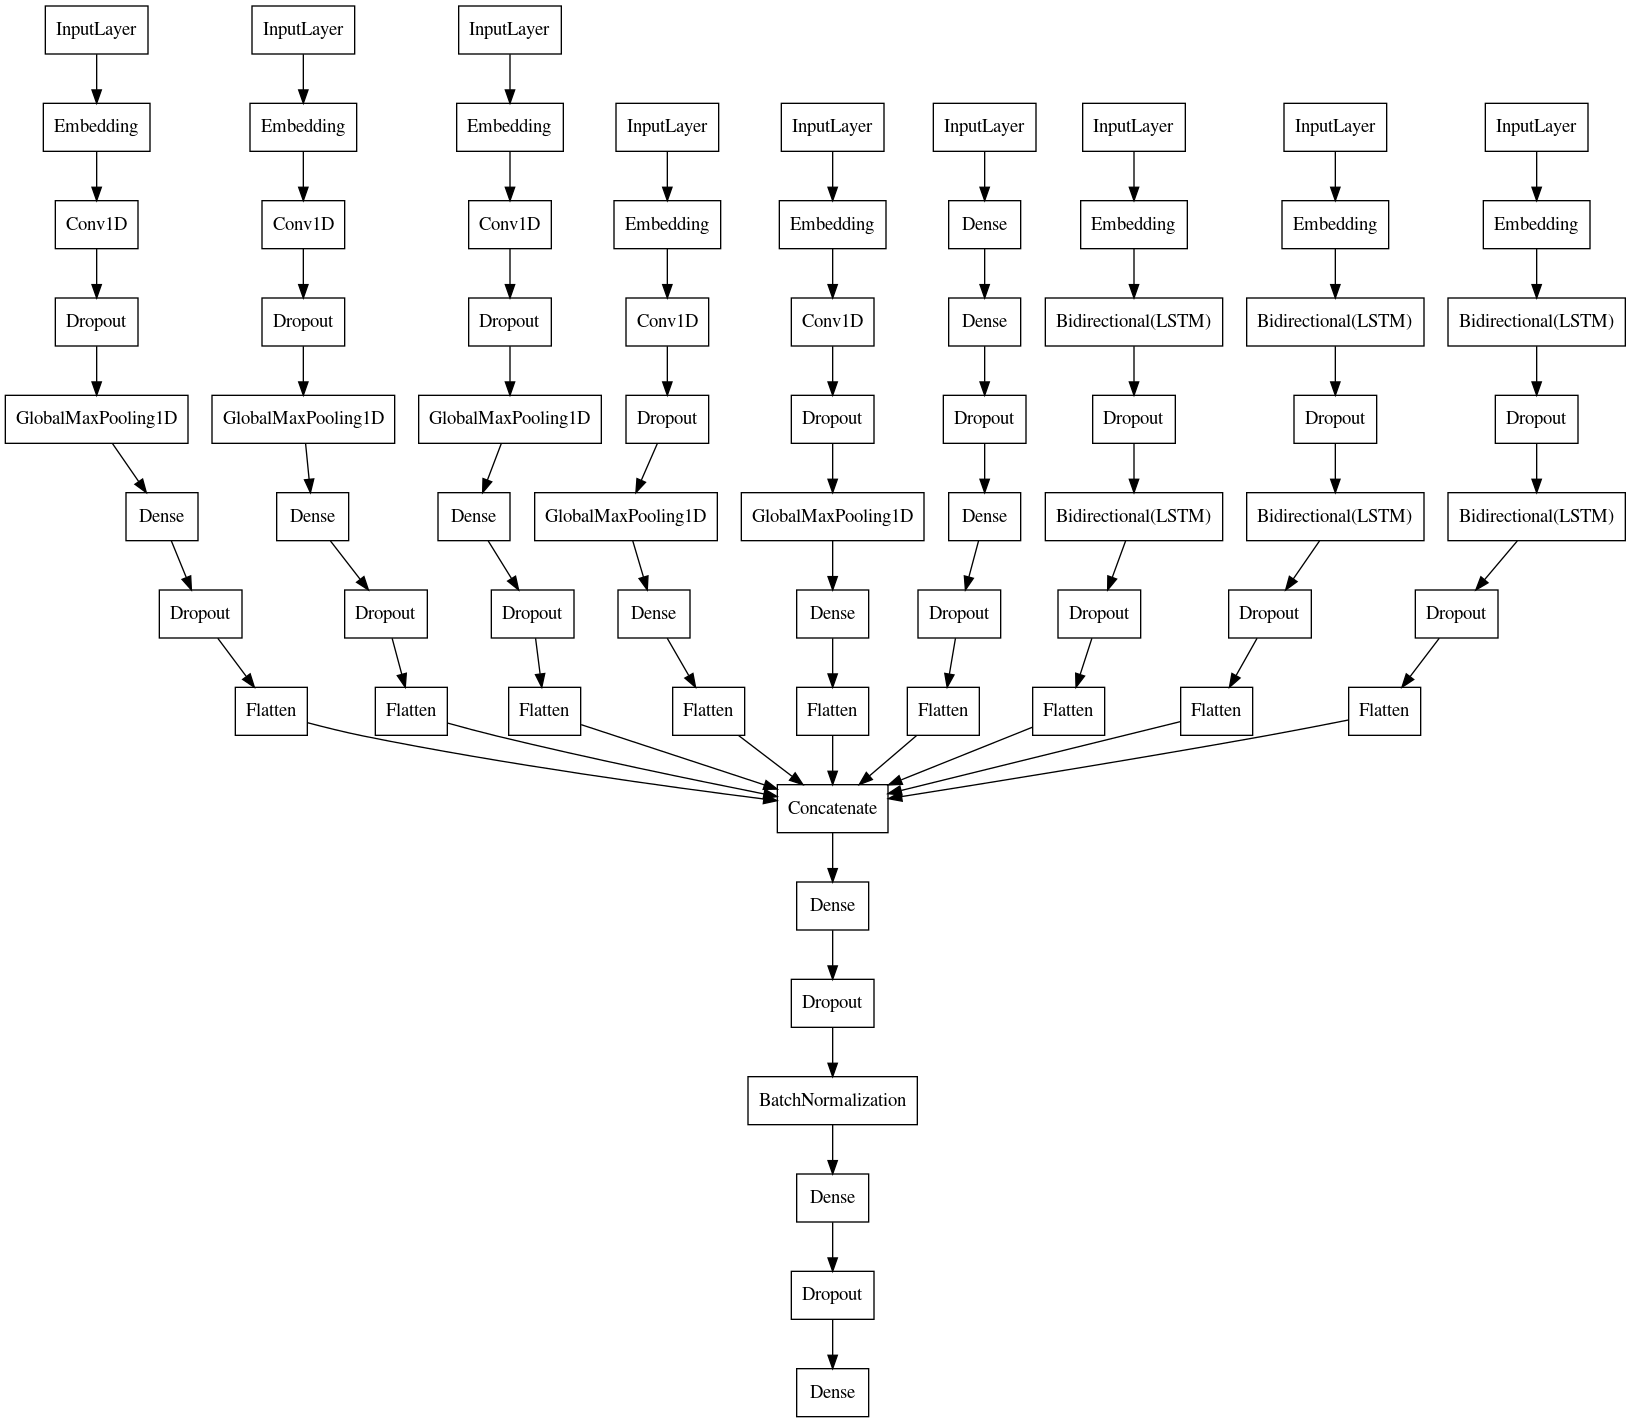

In [37]:
# plotting the entire model architecture
plot_model(model, to_file='model.png', show_layer_names=False)

In [38]:
# compiling the model
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [39]:
# combinig all the inputs

# train
all_inputs_train = [teacher_prefix_train, school_state_train, project_grade_category_train, subject_categories_train, subject_subcategories_train, \
                    previous_projects_train, project_title_train, project_resource_summary_train, project_essay_train]
                   

# val
all_inputs_val = [teacher_prefix_val, school_state_val, project_grade_category_val, subject_categories_val, subject_subcategories_val, \
                  previous_projects_val, project_title_val, project_resource_summary_val, project_essay_val]
                 
# test
all_inputs_test = [teacher_prefix_test, school_state_test, project_grade_category_test, subject_categories_test, subject_subcategories_test, \
                   previous_projects_test, project_title_test, project_resource_summary_test, project_essay_test]

In [40]:
# early stopping
early_stopping = EarlyStopping(monitor="val_loss", mode="auto", patience=5, restore_best_weights=True)

# learning rate
learning_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, mode='auto')

callbacks = [early_stopping, learning_rate]

In [41]:
# Training the Model
history = model.fit(all_inputs_train, y_train, batch_size=512, epochs=15, \
         validation_data=(all_inputs_val, y_val), callbacks=callbacks)

Epoch 1/15
285/285 [==============================] - 161s 564ms/step - loss: 0.4619 - accuracy: 0.8310 - auc: 0.6519 - val_loss: 0.4375 - val_accuracy: 0.8477 - val_auc: 0.7365 - lr: 0.0010
Epoch 2/15
285/285 [==============================] - 157s 551ms/step - loss: 0.3838 - accuracy: 0.8543 - auc: 0.7520 - val_loss: 0.3982 - val_accuracy: 0.8509 - val_auc: 0.7505 - lr: 0.0010
Epoch 3/15
285/285 [==============================] - 156s 547ms/step - loss: 0.3645 - accuracy: 0.8593 - auc: 0.7792 - val_loss: 0.4595 - val_accuracy: 0.8322 - val_auc: 0.7414 - lr: 0.0010
Epoch 4/15
285/285 [==============================] - 156s 549ms/step - loss: 0.3474 - accuracy: 0.8649 - auc: 0.8032 - val_loss: 0.3842 - val_accuracy: 0.8498 - val_auc: 0.7482 - lr: 0.0010
Epoch 5/15
285/285 [==============================] - 157s 550ms/step - loss: 0.3298 - accuracy: 0.8724 - auc: 0.8253 - val_loss: 0.5562 - val_accuracy: 0.8481 - val_auc: 0.7239 - lr: 0.0010
Epoch 6/15
285/285 [=========================

In [78]:
# making predictions on test data
test_pred = model.predict(all_inputs_test)

In [79]:
test_pred[:5]

array([[0.9451736 ],
       [0.9613482 ],
       [0.93028283],
       [0.95751107],
       [0.93287057]], dtype=float32)

In [44]:
sample['project_is_approved'] = test_pred

In [46]:
sample.to_csv('v4_dl.csv', index=False)